# ADCP processing

In [1]:
import os
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr

from scipy.io import loadmat

import pynsitu as pin

crs = pin.maps.crs

# drixmed utils
import utils as ut

In [2]:
root_dir = "/Users/aponte/Cloud/Ifremer/drixmed22"
campaign = "drixmed22"
yaml = f"python/{campaign}.yaml"

cp = pin.campaign(os.path.join(root_dir, yaml))

0-4351896
ctd
ship_europe


---
### load data

In [3]:
adcp_files = glob(os.path.join(cp.pathr, "ADCP/mat/*"))
adcp_files

['/Users/aponte/Cloud/Ifremer/drixmed22/data/raw/ADCP/mat/LatLong_Europe_L14.mat',
 '/Users/aponte/Cloud/Ifremer/drixmed22/data/raw/ADCP/mat/dir_Europe_L14.mat',
 '/Users/aponte/Cloud/Ifremer/drixmed22/data/raw/ADCP/mat/ADCP_Europe_20220921T182607_012_000000.mat',
 '/Users/aponte/Cloud/Ifremer/drixmed22/data/raw/ADCP/mat/ADCP_Europe_20220921T163350_011_000000.mat',
 '/Users/aponte/Cloud/Ifremer/drixmed22/data/raw/ADCP/mat/magnitude_Europe_L14.mat',
 '/Users/aponte/Cloud/Ifremer/drixmed22/data/raw/ADCP/mat/Velocity_Europe_L14.mat',
 '/Users/aponte/Cloud/Ifremer/drixmed22/data/raw/ADCP/mat/v_Europe_L14.mat',
 '/Users/aponte/Cloud/Ifremer/drixmed22/data/raw/ADCP/mat/u_Europe_L14.mat']

In [4]:
mat_u = loadmat(os.path.join(cp.pathr, "ADCP/mat/u_Europe_L14.mat"))
mat_v = loadmat(os.path.join(cp.pathr, "ADCP/mat/v_Europe_L14.mat"))
mat_ll = loadmat(os.path.join(cp.pathr, "ADCP/mat/LatLong_Europe_L14.mat"))

In [5]:
def extract_2D_field(mat, name, target_name, bad_value=None, scale=None, dtype=None):
    ds = xr.Dataset(
        {target_name: (("bin", "time"), mat[name].T)},
    )
    time = [
        pd.Timestamp(
            year=2000 + mat["ConYear"][i][0],
            month=mat["ConMonth"][i][0],
            day=mat["ConDay"][i][0],
            hour=mat["ConHour"][i][0],
            minute=mat["ConMin"][i][0],
            second=mat["ConSec"][i][0],
        )
        for i in range(ds.time.size)
    ]

    z = -float(mat["RDIBin1Mid"]) - float(mat["RDIBinSize"]) * np.arange(ds.bin.size)

    ds = ds.assign_coords(time=time, z=("bin", z))

    da = ds[target_name]
    if bad_value is not None:
        da = da.where(np.abs(da) < bad_value)
    if scale is not None:
        da = da * scale
    ds[target_name] = da

    return ds

In [6]:
ds_u = extract_2D_field(mat_u, "ConVel", "u", bad_value=10000, scale=1 / 1000)
ds_v = extract_2D_field(mat_v, "ConVel", "v", bad_value=10000, scale=1 / 1000)

ds = xr.merge([ds_u, ds_v])

ds = ds.assign_coords(
    lon=("time", mat_ll["AnFLonDeg"].squeeze()),
    lat=("time", mat_ll["AnFLatDeg"].squeeze()),
)
ds

<xarray.Dataset>
Dimensions:  (bin: 35, time: 380)
Coordinates:
  * time     (time) datetime64[ns] 2022-09-22T20:57:44 ... 2022-09-23T03:16:44
    z        (bin) float64 -7.2 -11.2 -15.2 -19.2 ... -135.2 -139.2 -143.2
    lon      (time) float64 5.231 5.231 5.231 5.231 ... 5.243 5.243 5.243 5.242
    lat      (time) float64 43.18 43.18 43.18 43.18 ... 43.1 43.1 43.1 43.1
Dimensions without coordinates: bin
Data variables:
    u        (bin, time) float64 -0.426 -0.448 -0.488 ... -32.77 -32.77 -32.77
    v        (bin, time) float64 0.213 0.156 0.23 0.243 ... -32.77 -32.77 -32.77

In [7]:
ds.time.max()

<xarray.DataArray 'time' ()>
array('2022-09-23T03:16:44.000000000', dtype='datetime64[ns]')

---

## plot fields

In [8]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmocean.cm as cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo

crs = ccrs.PlateCarree()


def plot_map(
    da=None,
    zoom=0,
    bathy=False,
    title=None,
    fig=None,
    ax=None,
    colorbar=True,
    colorbar_kwargs={},
    center_colormap=False,
    gridlines=True,
    dticks=(1, 1),
    land=True,
    coast_resolution="110m",
    offline=False,
    figsize=0,
    **kwargs,
):

    #
    if figsize == 0:
        _figsize = (10, 5)
    elif figsize == 1:
        _figsize = (20, 10)
    else:
        _figsize = figsize
    if fig is None:
        fig = plt.figure(figsize=_figsize)
    if ax is None:
        ax = fig.add_subplot(111, projection=ccrs.Orthographic(5.0, 43.0))

    # copy kwargs for update
    kwargs = kwargs.copy()

    if center_colormap and da is not None:
        vmax = float(abs(da).max())
        vmin = -vmax
        kwargs["vmin"] = vmin
        kwargs["vmax"] = vmax

    if bathy:
        da = load_bathy()
        da = da.rename(lon="longitude", lat="latitude")
        if "vmax" not in kwargs:
            kwargs.update(vmax=50)
        kwargs.update(cmap=cm.deep)

    if da is not None:
        im = da.squeeze().plot.pcolormesh(
            x="longitude",
            y="latitude",
            ax=ax,
            transform=crs,
            add_colorbar=False,
            **kwargs,
        )

    if isinstance(zoom, int):
        if zoom == 0:
            _extent = ax.get_extent()
            set_extent = False
        elif zoom == 1:
            _extent = [-1.0, 0.2, 49.25, 49.7]
            set_extent = True
        elif zoom == 2:
            _extent = [-0.6, 0.0, 49.25, 49.5]
            set_extent = True
    elif isinstance(zoom, list):
        _extent = zoom
        set_extent = True

    # coastlines and land:
    if land:
        dland = dict(scale="110m", edgecolor="face", facecolor=cfeature.COLORS["land"])
        if isinstance(land, dict):
            dland.update(**land)
            # land = dict(args=['physical', 'land', '10m'],
            #            kwargs= dict(edgecolor='face', facecolor=cfeature.COLORS['land']),
            #           )
        land_feature = cfeature.NaturalEarthFeature("physical", "land", **dland)
        # else:
        #    land_feature = cfeature.LAND
        ax.add_feature(land_feature, zorder=0)
    if coast_resolution is not None:
        ax.coastlines(resolution=coast_resolution, color="k")

    if set_extent:
        ax.set_extent(_extent)

    if da is not None and colorbar:
        # cbar = fig.colorbar(im, extend="neither", shrink=0.7, **colorbar_kwargs)
        axins = inset_axes(
            ax,
            width="5%",  # width = 5% of parent_bbox width
            height="100%",  # height : 50%
            loc="lower left",
            bbox_to_anchor=(1.05, 0.0, 1, 1),
            bbox_transform=ax.transAxes,
            borderpad=0,
        )
        # cbar = fig.colorbar(im, extend="neither", shrink=0.9,
        cbar = fig.colorbar(im, extend="neither", cax=axins, **colorbar_kwargs)
    else:
        cbar = None

    if gridlines:
        gl = ax.gridlines(
            draw_labels=True,
            dms=False,
            x_inline=False,
            y_inline=False,
        )
        gl.right_labels = False
        gl.top_labels = False

    if title is not None:
        ax.set_title(
            title,
            fontdict={
                "fontsize": 12,
            },
        )  # "fontweight": "bold"
    #
    return {"fig": fig, "ax": ax, "cbar": cbar}

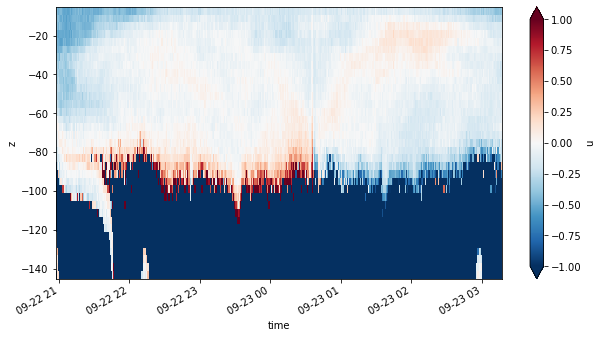

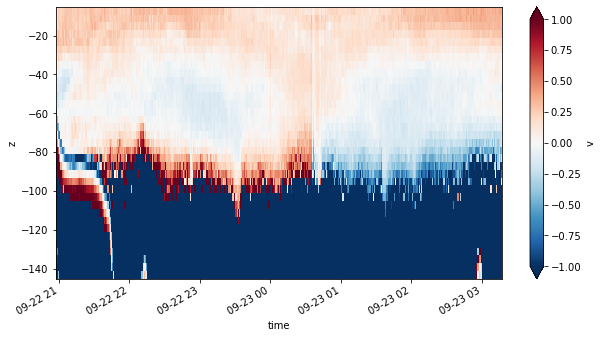

In [9]:
def plot2d(da, **kwargs):
    dkwargs = dict(y="z")
    dkwargs.update(**kwargs)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    da.plot(ax=ax, **dkwargs)


kwargs = dict(y="z")

plot2d(ds.u, vmax=1, **kwargs)
plot2d(ds.v, vmax=1, **kwargs)

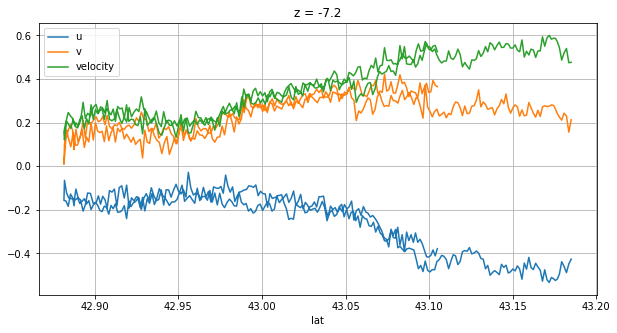

In [13]:
b = 0
# b = 10

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ds.u.isel(bin=b).plot(x="lat", label="u")
ds.v.isel(bin=b).plot(x="lat", label="v")
np.sqrt(ds.u**2 + ds.v**2).isel(bin=0).plot(x="lat", label="velocity")
ax.grid()
ax.legend()

In [31]:
# anchor point
lon_a, lat_a = 5.2475, 43.075

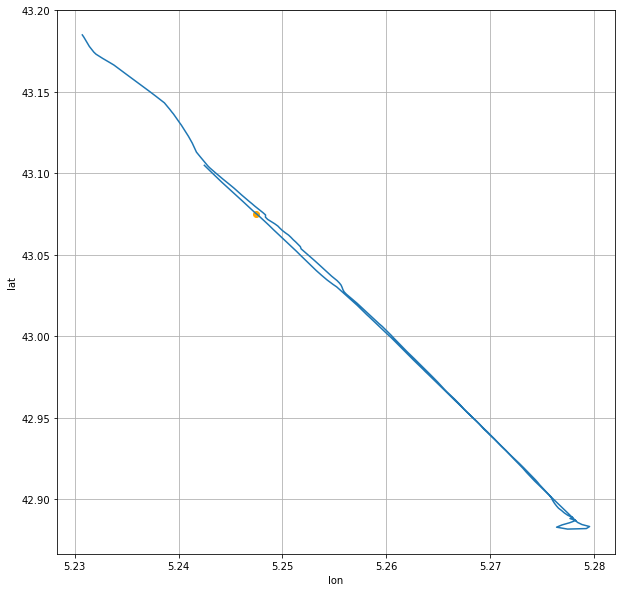

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ds.lat.plot(x="lon")
ax.scatter(lon_a, lat_a, c="orange")
ax.grid()

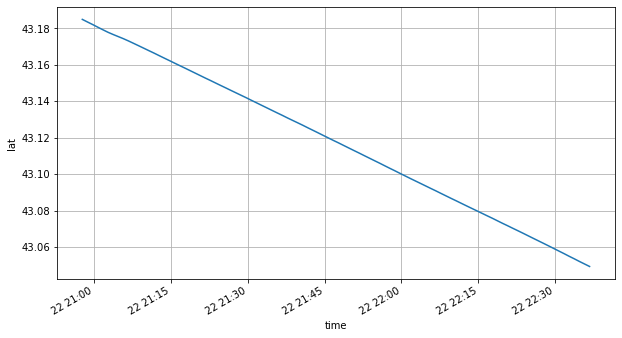

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ds.lat.isel(time=slice(0, 100)).plot()
ax.grid()

In [21]:
ds.sel(time="2022/09/22 22:20").isel(bin=0)

<xarray.Dataset>
Dimensions:  (time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2022-09-22T22:20:45
    z        float64 -7.2
    lon      (time) float64 5.249
    lat      (time) float64 43.07
Data variables:
    u        (time) float64 -0.298
    v        (time) float64 0.299

In [80]:
def plot_velocity(ds):

    extent = [5.0, 5.4, 42.85, 43.25]
    fac = plot_map(zoom=extent, figsize=(5, 15))
    ax = fac["ax"]

    _ds = ds.isel(time=slice(0, None, 3))

    ax.scatter(_ds.lon, _ds.lat, s=10, transform=crs)

    q = _ds.plot.quiver(
        x="lon", y="lat", u="u", v="v", scale=2, transform=crs, zorder=-2, pivot="tail"
    )
    qk = ax.quiverkey(
        q,
        0.1,
        0.9,
        0.5,
        "50 cm/s",
        transform=crs,
        color="r",
        labelpos="W",
        coordinates="axes",
        zorder=10,
    )

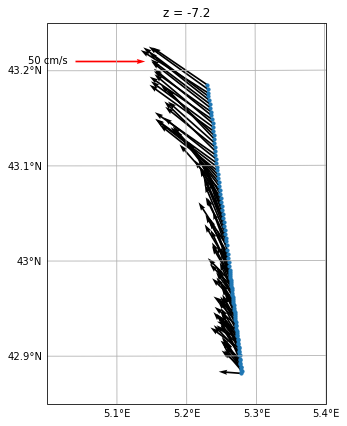

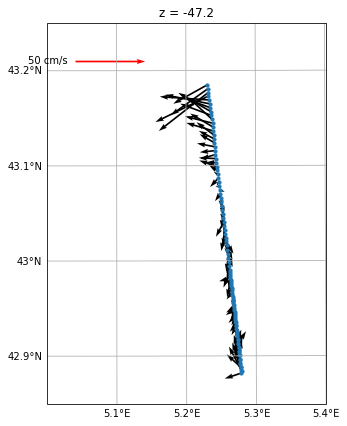

In [82]:
for b in [0, 10]:
    plot_velocity(ds.sel(bin=b))

In [ ]:
ds

In [56]:
# averaged time interval in seconds
(ds["time"].diff("time") / pd.Timedelta("1s")).mean()

<xarray.DataArray 'time' ()>
array(60.00338983)

In [83]:
0.1 * 60

6.0